**Общая информация**

**Срок сдачи:** 13 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 13 марта, -4 балла после 06:00 20 марта, -6 баллов после 06:00 27 марта

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе.

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn 4 балла для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 3 (2 балла)
Выполнить требования pep8

###### Задание 5 (2 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)


In [1]:
# python3.6
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
%load_ext pycodestyle_magic

In [2]:
# %%pycodestyle


class MyKNeighborsClassifier(
    NeighborsBase,
    KNeighborsMixin,
    SupervisedIntegerMixin,
    ClassifierMixin
):

    def __init__(self, n_neighbors):
        self.k = n_neighbors
        self.predict_data = None
        self.predict_class = None
        self.classes_numb = None

    def fit(self, x, y):
        self.predict_data = np.array(x)
        # cast required for use np.bincount() method
        self.predict_class = np.int64(np.array(y))
        self.classes_numb = np.unique(self.predict_class).shape[0]

    def predict(self, x):

        # Minkovsky metrics with p=2 calculation
        metrics = np.empty((self.predict_data.shape[0], x.shape[0]))
        for i in range(self.predict_data.shape[0]):
            metrics[i] = np.sqrt(np.sum(np.square(x - self.predict_data[i]),
                                        axis=1
                                        )
                                 )
        metrics = metrics.T

        # MemoryError on mnist
        # metrics = np.repeat(x, self.predict_data.shape[0], axis=0)
        # tmp = np.tile(self.predict_data, (x.shape[0], 1))
        # metrics -= tmp
        # metrics *= metrics
        # metrics = metrics.sum(axis=1)
        # metrics = np.sqrt(metrics)
        # metrics = metrics.reshape((-1, self.predict_data.shape[0]))

        # classes of the nearest rows from
        # predict_data to X rows (shape: (X.shape[0], k))
        neigh_classes = np.empty((self.k, x.shape[0]), dtype=np.int64)
        max_float64 = np.finfo(np.float64).max
        for i in range(self.k):
            tmp_arg = np.argmin(metrics, axis=1)
            neigh_classes[i] = self.predict_class[tmp_arg]
            metrics[np.arange(0, x.shape[0]), tmp_arg] = max_float64
        neigh_classes = neigh_classes.T

        # MemoryError on mnist
        # neigh_args = np.argpartition(metrics, self.k, axis=1)[:, :self.k]

        res = np.empty((x.shape[0],), dtype=np.int64)

        for i in range(x.shape[0]):
            res[i] = np.argmax(
                np.bincount(neigh_classes[i])
            )
        return res

    def predict_proba(self, x):

        # Minkovsky metrics with p=2 calculation
        metrics = np.empty((self.predict_data.shape[0], x.shape[0]))
        for i in range(self.predict_data.shape[0]):
            metrics[i] = np.sqrt(np.sum(np.square(x - self.predict_data[i]),
                                        axis=1
                                        )
                                 )
        metrics = metrics.T

        # classes of the nearest rows from
        # predict_data to X rows (shape: (X.shape[0], k))
        neigh_classes = np.empty((self.k, x.shape[0]), dtype=np.int64)
        max_float64 = np.finfo(np.float64).max
        for i in range(self.k):
            tmp_arg = np.argmin(metrics, axis=1)
            neigh_classes[i] = self.predict_class[tmp_arg]
            metrics[np.arange(0, x.shape[0]), tmp_arg] = max_float64
        neigh_classes = neigh_classes.T

        res = np.zeros((x.shape[0], self.classes_numb), dtype=np.float64)
        for i in range(x.shape[0]):
            elems, res[i][elems] = np.unique(neigh_classes[i, :],
                                             return_counts=True
                                             )

        res /= self.k
        return res

    def score(self, X, y):
        tmp = self.predict(X)
        mistakes = np.sum(np.bincount(np.abs(tmp - y))[1:])
        return 1.0 - mistakes / y.shape[0]


**IRIS**

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [6]:
%time clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 2.05 ms, total: 2.05 ms
Wall time: 20.8 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [7]:
%time my_clf.fit(X_train, y_train)

CPU times: user 329 µs, sys: 51 µs, total: 380 µs
Wall time: 283 µs


In [9]:
%time clf.predict(X_test)

CPU times: user 1.03 ms, sys: 159 µs, total: 1.19 ms
Wall time: 975 µs


array([0, 1, 2, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2, 1])

In [10]:
%time my_clf.predict(X_test)

CPU times: user 4.74 ms, sys: 107 µs, total: 4.85 ms
Wall time: 4.03 ms


array([0, 1, 2, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 2, 1])

In [11]:
%time clf.predict_proba(X_test)

CPU times: user 1.06 ms, sys: 165 µs, total: 1.22 ms
Wall time: 917 µs


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [12]:
%time my_clf.predict_proba(X_test)

CPU times: user 5.41 ms, sys: 212 µs, total: 5.62 ms
Wall time: 4.02 ms


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [13]:
clf.score(X_test, y_test)

1.0

In [14]:
my_clf.score(X_test, y_test)

1.0

17 - optimal n_neighbors value


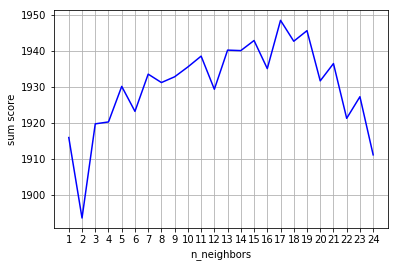

In [15]:
# %%pycodestyle
# Задание 3
# I run this a few times, for every time 17 is an optimal n_neighbors value

# with this parameters works a few seconds
max_n_neighbors = 25
iterations = 2000

neighbors = range(1, max_n_neighbors)

# sum score calculating
sum_score = [0.0 for _ in neighbors]
iris = datasets.load_iris()
for _ in range(iterations):
    X_train, X_test, y_train, y_test = train_test_split(
        iris.data, iris.target, test_size=0.1, stratify=iris.target
    )
    for i in neighbors:
        # MyKNeighborsClassifier works slower
        tmp_knn = KNeighborsClassifier(n_neighbors=i)
        tmp_knn.fit(X_train, y_train)
        sum_score[i - 1] += tmp_knn.score(X_test, y_test)
# plot stuff
plt.xticks(neighbors)
plt.ylabel('sum score')
plt.xlabel('n_neighbors')
plt.grid(b=True, axis='both')
plt.plot(neighbors, sum_score, color='blue', label='test')
print(np.argmax(np.array(sum_score)) + 1, '- optimal n_neighbors value')

**MNIST**

In [ ]:
mnist = fetch_mldata('MNIST original')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.1, stratify=mnist.target)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [ ]:
%time clf.fit(X_train, y_train)

In [ ]:
%time my_clf.fit(X_train, y_train)

In [ ]:
%time clf.predict(X_test)

In [ ]:
# MemoryError on my laptop
%time my_clf.predict(X_test)

In [ ]:
%time clf.predict_proba(X_test)

In [ ]:
# MemoryError on my laptop
%time my_clf.predict_proba(X_test)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
# MemoryError on my laptop
my_clf.score(X_test, y_test)

Задание 5

In [ ]:
# seaborn - библиотека для визуализации данных, основанная на matplotlib.
# Позволяет рисовать понятные статистические графики

# matplotlib - библиотека для рисования 2D графиков, позволяет рисовать
# статичные и интерактивные графики, работающие на разных платформах

# train_test_split - разбивает 2 матрицы (данные и результат) случайно
# на train и test части. Размеры частей можно указать.

# %load_extPipeline (from sklearn.pipeline import Pipeline) - 
# инструмент sklearn, который позволяет создавать "конвейер" 
# операций с данными и проводить финальную оценку работы.
# Один и тот же Pipeline можно применять много раз к разным данным. 

# StandardScaler (from sklearn.preprocessing import StandardScaler) -
# "стандартизирует" распределение признака так, что его 
# математическое ожидание становится = 0, а дисперсия  = 1

# ClassifierMixin - миксин (класс, использующийся для
# добавления функциональности в другие классы, не являтся базовым,
# уменьшает дублирование кода) для всех классификаторов sklearn.
# В данном миксине описан метод score

# NeighborsBase - базовый класс для оценочных функций, оценивающих
# работу инструментов, осонованных на алгоритме
# "ближайших соседей"

# KNeighborsMixin - миксин для поиска к ближайших соседей
# SupervisedIntegerMixin - миксин для работы с классификацией
# по конечному набору целых чисел